In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd '/content/drive/My Drive/Deep Learning Assignment'

/content/drive/My Drive/Deep Learning Assignment


In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models
import os
import random
from torch.optim import lr_scheduler

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(1)

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration, loss, x_label, y_label):
    plt.plot(iteration, loss)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
  
def show_vs_plot(iteration, train_acc, val_acc, x_label, y_label, mode):
    plt.plot(iteration, train_acc)
    plt.plot(iteration, val_acc)
    legend = ['train acc', 'val acc'] if mode == "acc" else ['train loss', 'val loss']
    loc = 'lower right' if mode == "acc" else 'upper right'
    plt.legend(legend, loc=loc)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [0]:
# resnet18 -> 96% testing accuracy
# resnet152 -> 100% testing accuracy (super slow to train, op accuracy -> dataset too less)

def build_network(model_name, pretrained=True):
  out_features = 112
  if model_name == "resnet18" or model_name == "resnet152":
    model = models.resnet18(pretrained) if model_name == "resnet18" else models.resnet152(pretrained)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, out_features)
    if not pretrained:
      for name, param in model.named_parameters():
        if not any(name.startswith(ext) for ext in ['layer3', 'layer4', 'fc']):
          param.requires_grad = False
  return model

In [0]:
def is_wrong_data_exist(img_name):
  if len(img_name.split('.')) != 2:
      return True
  return False

In [0]:
# CLEF 2011
CLEF_dataset_folder = "/content/drive/My Drive/Deep Learning Assignment/ImageCLEF2011FinalPackage/data"
test_GT = "testGroundTruth.txt"
train_GT = "trainGroundTruth.txt"

new_species = []
species_map_imgs = {}
num_imgs = 0

with open(os.path.join(CLEF_dataset_folder, test_GT)) as f:
  test_samples = [line.rstrip() for line in f.readlines()]
  for sample in test_samples:
    splited_info = sample.split(" ")
    species = "_".join(splited_info[:2]).lower().replace("-", "_")
    if species == "magnolia_grandiflora" or species == "ginkgo_biloba" or species == "nerium_oleander":
      species += "_l"
    if species == "pittosporum_tobira":
      species += "_aitf"
    new_species.append(species)
    img_names = [name for name in splited_info[2:] if not is_wrong_data_exist(name)]
    img_names = [os.path.join(CLEF_dataset_folder, "Test", image_name) for image_name in img_names]
    num_imgs += len(img_names)
    species_map_imgs[species] = img_names

with open(os.path.join(CLEF_dataset_folder, train_GT)) as f:
  train_samples = [line.rstrip() for line in f.readlines()]
  for sample in train_samples:
    splited_info = sample.split(" ")
    species = "_".join(splited_info[:2]).lower().replace("-", "_")
    if species == "magnolia_grandiflora" or species == "ginkgo_biloba" or species == "nerium_oleander":
      species += "_l"
    if species == "pittosporum_tobira":
      species += "_aitf"
    img_names = [name for name in splited_info[2:] if not is_wrong_data_exist(name)]
    img_names = [os.path.join(CLEF_dataset_folder, "Train", image_name) for image_name in img_names]
    num_imgs += len(img_names)
    species_map_imgs[species] += img_names

print("Total images", num_imgs)

Total images 5412


In [0]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2]
    return lst3 

dataset_folder = "/content/drive/My Drive/Deep Learning Assignment/plantSpeciesNew"

current_species = []
for plant_name_folder in os.listdir(dataset_folder):
  current_species.append(plant_name_folder)

print(len(current_species))
print(len(new_species))
print("Overlapped species", intersection(new_species, current_species))

47
71
Overlapped species ['acer_platanoides', 'pittosporum_tobira_aitf', 'fagus_sylvatica', 'nerium_oleander_l', 'ginkgo_biloba_l', 'magnolia_grandiflora_l']


In [0]:

combine_dataset = True

# Flavia + Swedish
dataset_folder = "/content/drive/My Drive/Deep Learning Assignment/plantSpeciesNew"
plant_names = []
samples = []
training_samples = []
validation_samples = []
testing_samples = []

label = -1
for plant_name_folder in os.listdir(dataset_folder):
  label += 1
  plant_names.append(plant_name_folder) 
  for img_name in os.listdir(os.path.join(dataset_folder, plant_name_folder)):
    img_path = os.path.join(dataset_folder, plant_name_folder, img_name)
    samples.append({"img_path": img_path, "label": label})

if combine_dataset:
  for species, image_paths in species_map_imgs.items():
    # existing species
    existed_species = species in plant_names
    if not existed_species:
      label += 1
      plant_names.append(species)
    for img_path in image_paths:
      samples.append({"img_path": img_path, "label": plant_names.index(species) if existed_species else label})

random.shuffle(samples)
training_samples = samples[:int(0.8*len(samples))]
validation_samples = samples[int(0.8*len(samples)):int(0.9*len(samples))]
testing_samples = samples[int(0.9*len(samples)):]

print("Total samples:", len(samples))
print("Total training_samples:", len(training_samples))
print("Total validation_samples:", len(validation_samples))
print("Total testing_samples:", len(testing_samples))
print("Total species:", len(plant_names))
print("Total label:", label)
for name in plant_names:
  print(name)

Total samples: 8456
Total training_samples: 6764
Total validation_samples: 846
Total testing_samples: 846
Total species: 112
Total label: 111
aesculus_chinensis
acer_platanoides
acer_palmatum
alnus_incana
cercis_chinensis
cedrus_deodara_g_don
berberis_anhweiensis_ahrendt
chimonanthus_praecox_l
acer_buergerianum_miq
betula_pubescens
kalopanax_septemlobus_koidz
fagus_sylvatica
citrus_reticulata_blanco
ginkgo_biloba_l
cinnamomum_camphora_j_presl
cinnamomum_japonicum_sieb
koelreuteria_paniculata_laxmi
ilex_macrocarpa_oliv
indigofera_tinctoria_l
lagerstroemia_indica_pers
pittosporum_tobira_aitf
osmanthus_fragrans_lour
phyllostachys_edulis
magnolia_grandiflora_l
nerium_oleander_l
phoebe_nanmu_gamble
liriodendron_chinense_sarg
mahonia_bealei_carr
ligustrum_lucidum_ait_f
manglietia_fordiana_oliv
prunus_persica_batsch
salix_alba
populus
prunus_serrulata_lindl_var_lannesiana_auct
populus_canadensis_moench
podocarpus_macrophyllus_sweet
populus_tremula
salix_sinerea
quercus
salix_aurita
tilia
ulmu

In [0]:
class LeafDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.transform = transform
        self.samples = samples

    def __getitem__(self, index):
        
        leaf_img = Image.open(self.samples[index]["img_path"])
        leaf_label = self.samples[index]["label"]

        if self.transform is not None:
          leaf_img = self.transform(leaf_img)
        
        return leaf_img, leaf_label
    
    def __len__(self):
        return len(self.samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


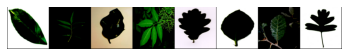

[ 44  58 102  97  38  59  84 111]


In [0]:
leaf_dataset = LeafDataset(training_samples,
                          transform=transforms.Compose([
                                                        transforms.Resize((224,224)),
                                                        transforms.RandomHorizontalFlip(),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                      ])
                          )

vis_dataloader = DataLoader(leaf_dataset,
                        shuffle=True,
                        num_workers=1,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
imshow(torchvision.utils.make_grid(example_batch[0]))
print(example_batch[1].numpy())

In [0]:
net = build_network(model_name="resnet152", pretrained=True).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [0]:
training_dataset = LeafDataset(training_samples,
                           transform=transforms.Compose([
                                                        transforms.Resize((224,224)),
                                                        transforms.RandomHorizontalFlip(),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                        ])
                )

train_dataloader = DataLoader(training_dataset,
                    shuffle=True,
                    num_workers=4,
                    batch_size=32)

In [0]:
validation_dataset = LeafDataset(validation_samples,
                           transform=transforms.Compose([
                                                        transforms.Resize((224,224)),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                        ])
                )

validation_dataloader = DataLoader(validation_dataset,
                    shuffle=True,
                    num_workers=4,
                    batch_size=32)

In [0]:
def evaluate(dataloader, num_samples):
  y_pred = []
  y_true = []
  corrects = 0
  loss = 0
  net.train(mode=False)
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
        img, targets = data
        img, targets = img.cuda(), targets.cuda()
        output = net(img)
        probs = torch.softmax(output, dim=1)
        preds = probs.argmax(dim=1)
        corrects += (preds == targets).sum().float()
        loss += criterion(output, targets).item()
        y_true += [plant_names[target] for target in targets]
        y_pred += [plant_names[pred] for pred in preds]
  accuracy = corrects / num_samples * 100
  loss /= num_samples
  return accuracy, loss, y_true, y_pred


In [0]:
counter = []
train_loss_history = [] 
val_loss_history = [] 
training_accuracy_history = []
validation_accuracy_history = []
iteration_number= 0
max_epochs = 30
best_loss = float('inf')

net.train(mode=True)
for epoch in range(0, max_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img, target = data
        img, target = img.cuda(), target.cuda()
        optimizer.zero_grad()
        output = net(img)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(net.state_dict(), './leaf_classifier_model.pth')
        if i % 10 == 0 :
            probs = torch.softmax(output, dim=1)
            winners = probs.argmax(dim=1)
            corrects = (winners == target)
            training_accuracy = corrects.sum().float() / float(target.size(0)) * 100
            validation_accuracy, valid_loss = evaluate(validation_dataloader, len(validation_samples))
            net.train(mode=True)
            print("Epoch number: {}\nTraining loss: {}\nTraining accuracy: {}%\n Validation accuracy: {}%\n".format(epoch, loss.item(),  training_accuracy, validation_accuracy))
            iteration_number += 10
            counter.append(iteration_number)
            train_loss_history.append(loss.item())
            val_loss_history.append(valid_loss)
            training_accuracy_history.append(training_accuracy)
            validation_accuracy_history.append(validation_accuracy)
    scheduler.step()

Epoch number: 0
Training loss: 4.802458763122559
Training accuracy: 3.125%
 Validation accuracy: 6.5011820793151855%

Epoch number: 0
Training loss: 4.604455471038818
Training accuracy: 0.0%
 Validation accuracy: 0.9456264972686768%

Epoch number: 0
Training loss: 4.554247856140137
Training accuracy: 3.125%
 Validation accuracy: 1.063829779624939%

Epoch number: 0
Training loss: 4.854221820831299
Training accuracy: 6.25%
 Validation accuracy: 2.127659559249878%

Epoch number: 0
Training loss: 4.372814655303955
Training accuracy: 0.0%
 Validation accuracy: 4.846335411071777%

Epoch number: 0
Training loss: 3.8759355545043945
Training accuracy: 9.375%
 Validation accuracy: 6.264775276184082%

Epoch number: 0
Training loss: 3.9197356700897217
Training accuracy: 3.125%
 Validation accuracy: 6.973995208740234%

Epoch number: 0
Training loss: 4.012369155883789
Training accuracy: 6.25%
 Validation accuracy: 9.338061332702637%

Epoch number: 0
Training loss: 4.107794761657715
Training accuracy

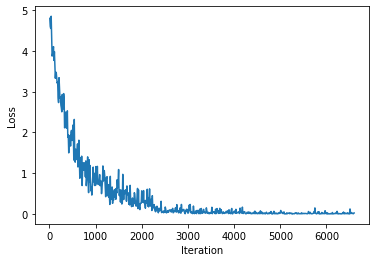

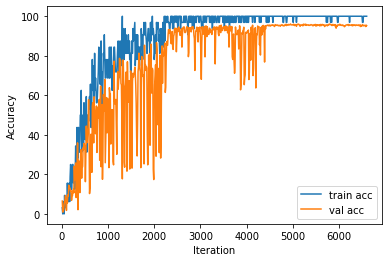

In [0]:
show_plot(counter, train_loss_history, "Iteration", "Loss")
# show_vs_plot(counter, train_loss_history, val_loss_history, "Iteration", "Loss", "loss")
show_vs_plot(counter, training_accuracy_history, validation_accuracy_history, "Iteration", "Accuracy", "acc")

In [0]:
testing_dataset = LeafDataset(testing_samples,
                              transform=transforms.Compose([
                                                        transforms.Resize((224,224)),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                        ])
                  )

test_dataloader = DataLoader(testing_dataset,
                    shuffle=True,
                    num_workers=4,
                    batch_size=64)

In [0]:
net.eval()
testing_acc, _, y_true, y_pred = evaluate(test_dataloader, len(testing_samples))
print("Testing accuracy: {}%".format(testing_acc))

from sklearn.metrics import precision_recall_fscore_support
micro_precision_recall_fscore = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=1)
macro_precision_recall_fscore = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)
print("Average micro precision {} recall {} fscore {}".format(micro_precision_recall_fscore[0], micro_precision_recall_fscore[1], micro_precision_recall_fscore[2]))
print("Average macro precision {} recall {} fscore {}".format(macro_precision_recall_fscore[0], macro_precision_recall_fscore[1], macro_precision_recall_fscore[2]))

Testing accuracy: 94.68085479736328%
Average micro precision 0.9468085106382979 recall 0.9468085106382979 fscore 0.9468085106382979
Average macro precision 0.9365136880819402 recall 0.9439955849729281 fscore 0.9301753892593198


In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision["micro"], recall["micro"], _ = precision_recall_curve(y_true, y_pred)
average_precision["micro"] = average_precision_score(y_true, y_pred, average="micro")

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

ValueError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


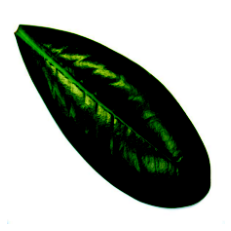

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


magnolia_grandiflora_l


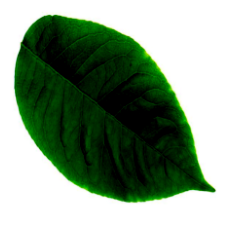

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ilex_macrocarpa_oliv


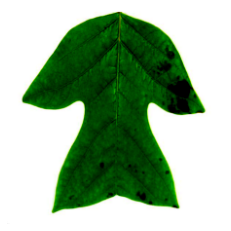

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


liriodendron_chinense_sarg


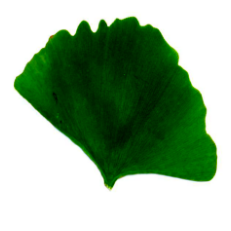

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ginkgo_biloba_l


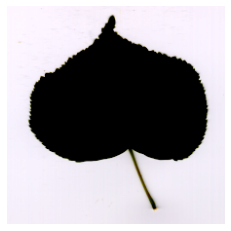

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


populus


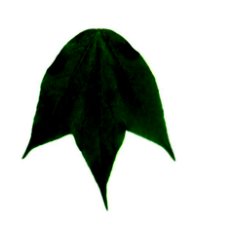

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


acer_buergerianum_miq


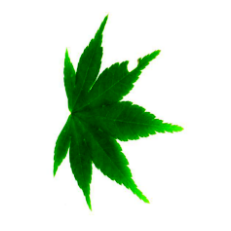

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


acer_palmatum


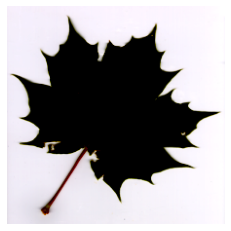

acer_platanoides


In [0]:
# manual testing
transform=transforms.Compose([
                              transforms.Resize((224,224)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])
img_names = [
            "magnolia_grandiflora_l/3390.jpg",
            "ilex_macrocarpa_oliv/2047.jpg",
            "liriodendron_chinense_sarg/3563.jpg",
            "ginkgo_biloba_l/2483.jpg",
            "populus/l12nr008.tif",
            "acer_buergerianum_miq/3331.jpg",
            "acer_palmatum/1323.jpg",
            "acer_platanoides/l2nr046.tif"   
]

for img_name in img_names:
  img_path = os.path.join(dataset_folder, img_name)
  img = Image.open(img_path)
  img = transform(img)
  imshow(img)
  img = img.unsqueeze(0).cuda()
  out = net(img)
  probs = torch.softmax(out, dim=1)
  idx = probs.argmax(dim=1).item()
  print(plant_names[idx])